In [1]:
import warnings

warnings.filterwarnings("ignore")

import joblib
import pandas as pd
import tensorflow as tf
import numpy as np
import shap
import xgboost

from modeling import *
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline

In [2]:
pipeline = joblib.load("../pipelines/feature_engineering_pipeline.joblib")
df = pd.read_csv("../data/orig_train.csv")
df = pipeline.fit_transform(df)
df_val = pd.read_csv("../data/orig_valid.csv")
df_val = pipeline.transform(df_val)

# Testing models

In [3]:
X_train = df.drop(columns="FINALIZED_LOAN")
y_train = df["FINALIZED_LOAN"]

X_val = df_val.drop(columns="FINALIZED_LOAN")
y_val = df_val["FINALIZED_LOAN"]

## Traditional ML

Let's start with searching for most promising models with default parameters, to save computing power. We'll keep track mostly of their f1 score and roc auc.

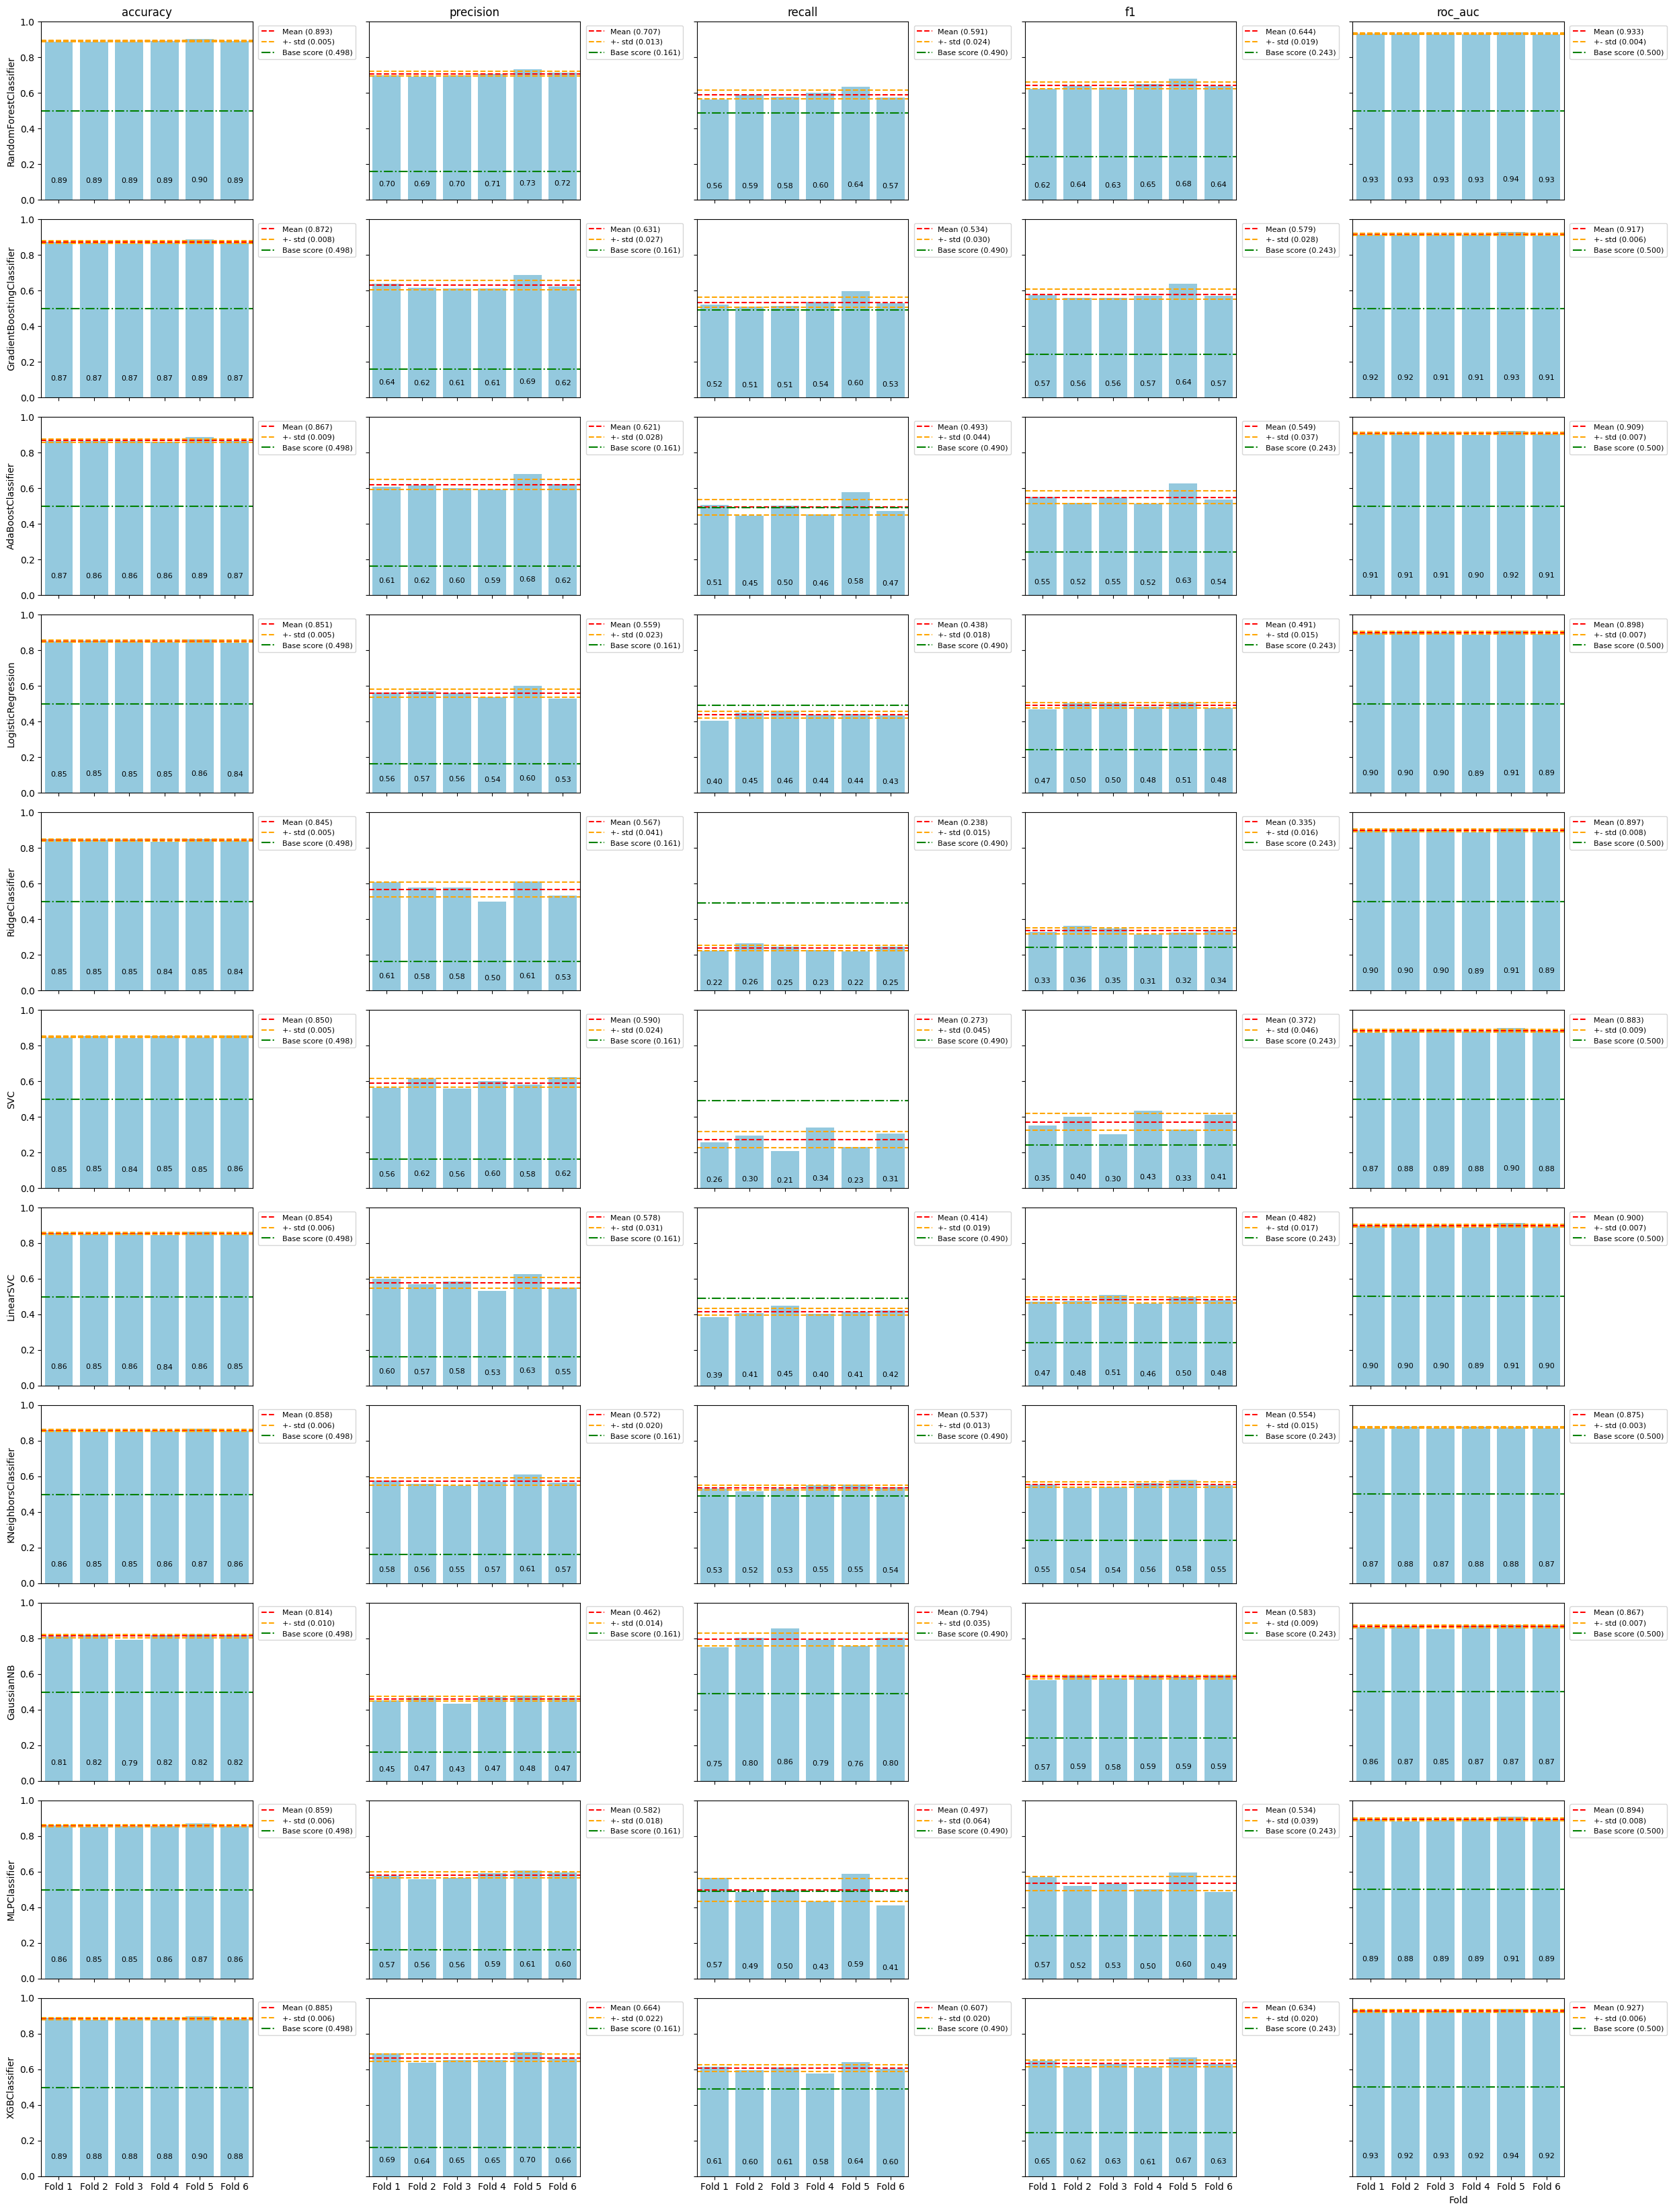

In [4]:
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(algorithm="SAMME"),
    LogisticRegression(max_iter=4000, dual=False),
    RidgeClassifier(),
    SVC(max_iter=4000),
    LinearSVC(dual=False, max_iter=4000),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter=4000),
    XGBClassifier(),
]

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

scores = my_cross_validate(models, X_train, y_train, scoring=scoring)

What's important is also to pay attention to base score (green lines). It's relatively low, it's a dummy classifier that outputs uniform class from results. 

<Figure size 1200x800 with 0 Axes>

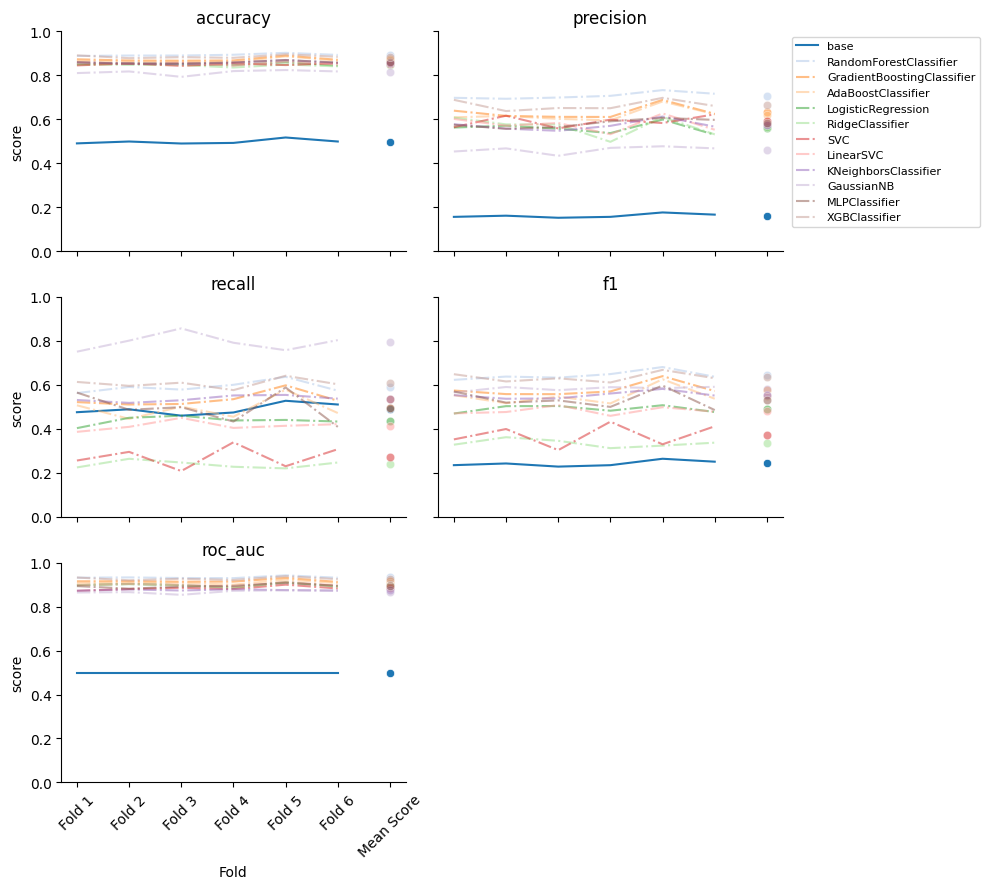

In [5]:
plot_scoring(scoring, scores)

In [6]:
print_scores(scores, "recall")

Models recall
	GaussianNB                    0.7938857111664775
	XGBClassifier                 0.6066934921024825
	RandomForestClassifier        0.5905719120531207
	KNeighborsClassifier          0.5373158188191348
	GradientBoostingClassifier    0.5344948591079762
	MLPClassifier                 0.496947047057585
	AdaBoostClassifier            0.49333848007392583
	LogisticRegression            0.437690322178163
	LinearSVC                     0.41429117294997914
	SVC                           0.2726973209655597
	RidgeClassifier               0.23840813652899137


In [7]:
print_scores(scores, "f1")

Models f1
	RandomForestClassifier        0.6436123860097299
	XGBClassifier                 0.6340540027889251
	GaussianNB                    0.5831107786032614
	GradientBoostingClassifier    0.5788268852569985
	KNeighborsClassifier          0.5539355850935707
	AdaBoostClassifier            0.5492881373776033
	MLPClassifier                 0.5336105247883204
	LogisticRegression            0.49069298061651995
	LinearSVC                     0.48191654627497477
	SVC                           0.37152547802315067
	RidgeClassifier               0.3348761905954387


In [8]:
print_scores(scores, "roc_auc")

Models roc_auc
	RandomForestClassifier        0.9329136509618493
	XGBClassifier                 0.9271466976381806
	GradientBoostingClassifier    0.9167174808016347
	AdaBoostClassifier            0.9088979595380599
	LinearSVC                     0.8995210164868662
	LogisticRegression            0.8981257017506247
	RidgeClassifier               0.89739705341036
	MLPClassifier                 0.8938190855011617
	SVC                           0.8831598680627386
	KNeighborsClassifier          0.8749405763990152
	GaussianNB                    0.8670563180878653


Science we predict whether client will be granted with a credit, we're more interested with high recall not high precision - after all, we'd prefer to guess that more people will be granted one than to discourage them from trying to.

Therefore further we'll proceed with GaussianNB (highest recall) and XGB Classifier (it can be greatly fine-tuned) and SVC (second highest recall).

Let's fine-tune parameters of models of our choice. We'll use optuna for optimized search of param space. For XGBClassifier we'll stick with relatively shallow trees to avoid overfitting, although below search suggest that deeper trees might lead to better results.

In [9]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
            "max_depth": trial.suggest_int("max_depth", 3, 50),
            "eta": trial.suggest_loguniform("eta", 0.01, 0.5),
            "gamma": trial.suggest_loguniform("gamma", 1e-3, 10.0),
            "grow_policy": trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            ),
        }
        return after_params_objective(params, X_train, y_train, model_class)

    return objective


study = optimize(X_train, y_train, XGBClassifier, create_objective, 100)
xgb_params = study.best_trial.params

[I 2024-05-07 12:48:39,497] A new study created in memory with name: no-name-8aee7d00-5a73-4e4c-ab0f-954e3f780e79
[I 2024-05-07 12:48:39,897] Trial 0 finished with value: 0.8795790237985035 and parameters: {'booster': 'gbtree', 'lambda': 0.018037964044757947, 'alpha': 3.057441132016812, 'max_depth': 34, 'eta': 0.13479707216914075, 'gamma': 0.8900270286348808, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8795790237985035.
[I 2024-05-07 12:49:07,957] Trial 1 finished with value: 0.887594023721727 and parameters: {'booster': 'dart', 'lambda': 0.006925001119147206, 'alpha': 0.01047172774731399, 'max_depth': 42, 'eta': 0.09728661956696026, 'gamma': 0.0038022406390764403, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.887594023721727.
[I 2024-05-07 12:49:31,983] Trial 2 finished with value: 0.8699745979656436 and parameters: {'booster': 'dart', 'lambda': 9.685228216190977, 'alpha': 3.0575281269354124, 'max_depth': 27, 'eta': 0.16903323083753607, 'gamma': 7.939774531

In [10]:
xgb_classifier = create_best_estimator(
    study, X_train, y_train, X_val, y_val, XGBClassifier
)

Number of finished trials: 100
Best trial:
  Value: 0.8907731168383899
  Params: 
    booster: dart
    lambda: 5.300729413321117
    alpha: 0.004373402847043272
    max_depth: 46
    eta: 0.36324883963950516
    gamma: 0.0014298698374813413
    grow_policy: depthwise
Refitted best model f1-score on valid: 0.8905718701700155


Although model looks very promising, we need to keep in mind that what is in our best interest is recall on "1" class, which is weakest part of our model indicating that this prediction is not that easy after all.

In [11]:
my_classification_report(xgb_classifier, X_val, y_val)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2734
           1       0.66      0.60      0.63       501

    accuracy                           0.89      3235
   macro avg       0.79      0.77      0.78      3235
weighted avg       0.89      0.89      0.89      3235

ROC AUC score: 0.7730504608924068


In [12]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        params = {
            "var_smoothing": trial.suggest_loguniform("var_smoothing", 1e-10, 10.0)
        }
        cv_scores = cross_val_score(
            model_class(**params),
            X_train,
            y_train,
            cv=5,
            scoring="roc_auc",
            n_jobs=-1,
        )
        return cv_scores.mean()

    return objective


study = optimize(X_train, y_train, GaussianNB, create_objective, 100)

[I 2024-05-07 14:49:03,912] A new study created in memory with name: no-name-3429dd1d-9b07-413e-8e85-4a601d92ec2e
[I 2024-05-07 14:49:04,972] Trial 0 finished with value: 0.7341777245874355 and parameters: {'var_smoothing': 4.403301508949185}. Best is trial 0 with value: 0.7341777245874355.
[I 2024-05-07 14:49:05,558] Trial 1 finished with value: 0.8664967117441928 and parameters: {'var_smoothing': 6.168790509963679e-08}. Best is trial 1 with value: 0.8664967117441928.
[I 2024-05-07 14:49:06,090] Trial 2 finished with value: 0.7953366057981006 and parameters: {'var_smoothing': 0.24084111208399706}. Best is trial 1 with value: 0.8664967117441928.
[I 2024-05-07 14:49:06,624] Trial 3 finished with value: 0.868257833302947 and parameters: {'var_smoothing': 1.2206432200134971e-06}. Best is trial 3 with value: 0.868257833302947.
[I 2024-05-07 14:49:06,782] Trial 4 finished with value: 0.8664809675672778 and parameters: {'var_smoothing': 5.3957675156367376e-08}. Best is trial 3 with value: 0.

In [13]:
gaussian_classifier = create_best_estimator(
    study, X_train, y_train, X_val, y_val, GaussianNB
)

Number of finished trials: 100
Best trial:
  Value: 0.8927364293893408
  Params: 
    var_smoothing: 9.026696330003137e-05
Refitted best model f1-score on valid: 0.8278207109737249


In [14]:
my_classification_report(gaussian_classifier, X_val, y_val)

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      2734
           1       0.47      0.85      0.60       501

    accuracy                           0.83      3235
   macro avg       0.72      0.84      0.75      3235
weighted avg       0.89      0.83      0.85      3235

ROC AUC score: 0.8361853469359743


For SVC we limited max_iter to 5000 to save computer power. It might be better accomplished with changing stopping tolerance, although final model did manage to coverage withing 5000 iteration with default tolerance of 1e-03.

In [15]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        C = trial.suggest_loguniform("C", 1e-5, 1e5)
        kernel = trial.suggest_categorical(
            "kernel", ["linear", "poly", "rbf", "sigmoid"]
        )
        max_iter = trial.suggest_categorical("max_iter", [5000])
        probability = trial.suggest_categorical("probability", [True])

        if kernel == "poly":
            degree = trial.suggest_int("degree", 2, 5)
        else:
            degree = 3

        if kernel in ["rbf", "poly", "sigmoid"]:
            gamma = trial.suggest_loguniform("gamma", 1e-5, 1e5)
        else:
            gamma = "scale"

        params = {
            "C": C,
            "kernel": kernel,
            "degree": degree,
            "gamma": gamma,
            "max_iter": max_iter,
            "probability": probability,
        }
        return after_params_objective(params, X_train, y_train, model_class)

    return objective


study = optimize(X_train, y_train, SVC, create_objective, 40)

[I 2024-05-07 13:23:40,437] A new study created in memory with name: no-name-a5d70976-a075-4645-818f-6a667953d17f
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
[I 2024-05-07 13:24:10,906] Trial 0 finished with value: 0.7233895263770952 and parameters: {'C': 1.2182190216708606, 'kernel': 'sigmoid', 'max_iter': 5000, 'probability': True, 'gamma': 0.13562134091879874}. Best is trial 0 with value: 0.7233895263770952.
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver

In [16]:
svc_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, SVC)

Number of finished trials: 40
Best trial:
  Value: 0.8767968868249433
  Params: 
    C: 22208.56815131227
    kernel: rbf
    max_iter: 5000
    probability: True
    gamma: 0.26672481100997353
Refitted best model f1-score on valid: 0.8809891808346213


In [17]:
my_classification_report(svc_classifier, X_val, y_val)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2734
           1       0.68      0.44      0.53       501

    accuracy                           0.88      3235
   macro avg       0.79      0.70      0.73      3235
weighted avg       0.87      0.88      0.87      3235

ROC AUC score: 0.7005411269633374


Lets try voting classifier

In [18]:
ensemble_clf = VotingClassifier(
    estimators=[
        ("XGBClassifier", xgb_classifier),
        ("GaussianNB", gaussian_classifier),
        ("SVC", svc_classifier),
    ],
    voting="soft",
)

ensemble_clf.fit(X_train, y_train)
y_pred = ensemble_clf.predict(X_val)
score = f1_score(y_val, y_pred, average="micro")

print(f"Refitted best model f1-score on valid: {score}")

Refitted best model f1-score on valid: 0.8846986089644513


In [19]:
my_classification_report(ensemble_clf, X_val, y_val)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2734
           1       0.61      0.69      0.65       501

    accuracy                           0.88      3235
   macro avg       0.78      0.80      0.79      3235
weighted avg       0.89      0.88      0.89      3235

ROC AUC score: 0.8046259346705272


So as it turns out best model in term of "1" class recall is Gaussian Classifier, which for now is our choice. It's also worth noting that this model is very light-weighted, so CD will be cost-effective and its serving will be cheap.

## Deep Learning

In [20]:
def get_simple_model(dropout=0.2):
    return tf.keras.Sequential(
        [
            layers.Dense(256, input_shape=(X_train.shape[1],)),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(dropout),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(64),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(dropout),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8332 - loss: 0.3488 - val_AUC: 0.8964 - val_loss: 0.2707 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8948 - loss: 0.2771 - val_AUC: 0.8952 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9023 - loss: 0.2698 - val_AUC: 0.8996 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9022 - loss: 0.2709 - val_AUC: 0.8984 - val_loss: 0.2650 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9119 - loss: 0.2576 - val_AUC: 0.9001 - val_loss: 0.2659 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9051 - loss: 0.2722 - val_AUC: 0.9011 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9145 - loss: 0.2535 - val_AUC: 0.9024 - val_loss: 0.2612 - learning_rate: 5.0000

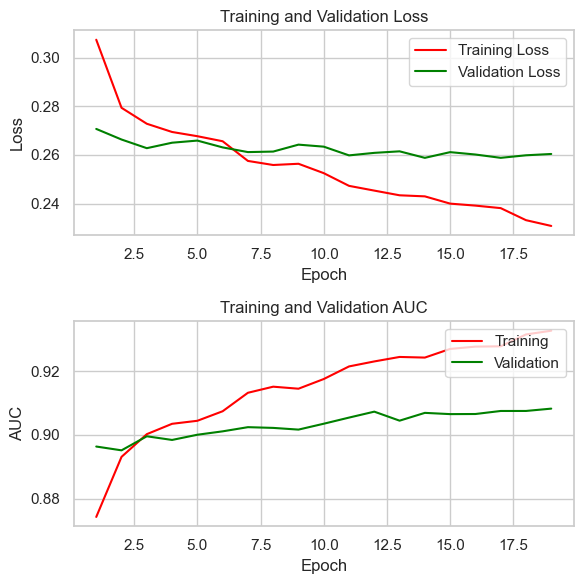

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2734
           1       0.58      0.45      0.50       501

    accuracy                           0.86      3235
   macro avg       0.74      0.69      0.71      3235
weighted avg       0.85      0.86      0.86      3235

ROC AUC score: 0.6931108521800583


In [21]:
simple_classifier_02 = get_simple_model()
simple_classifier_02.summary()
history = train_model(simple_classifier_02, X_train, y_train, X_val, y_val)
plot_history(history)
my_classification_report(simple_classifier_02, X_val, y_val)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8577 - loss: 0.3258 - val_AUC: 0.8941 - val_loss: 0.2707 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8990 - loss: 0.2709 - val_AUC: 0.8893 - val_loss: 0.2753 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8976 - loss: 0.2740 - val_AUC: 0.8949 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9044 - loss: 0.2709 - val_AUC: 0.8986 - val_loss: 0.2665 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9070 - loss: 0.2580 - val_AUC: 0.9022 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9129 - loss: 0.2556 - val_AUC: 0.8986 - val_loss: 0.2670 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9121 - loss: 0.2577 - val_AUC: 0.8989 - val_loss: 0.2657 - learning_rate: 0.0010

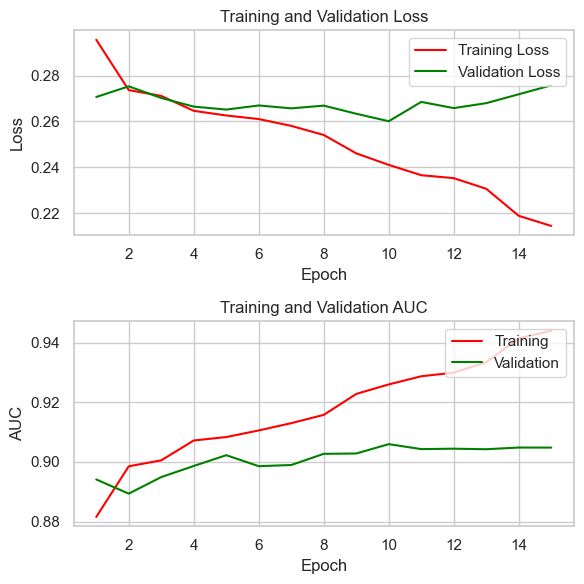

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2734
           1       0.57      0.46      0.51       501

    accuracy                           0.86      3235
   macro avg       0.74      0.70      0.71      3235
weighted avg       0.85      0.86      0.86      3235

ROC AUC score: 0.6962720499016597


In [22]:
simple_classifier_00 = get_simple_model(dropout=0.0)
simple_classifier_00.summary()
history = train_model(simple_classifier_00, X_train, y_train, X_val, y_val)
plot_history(history)
my_classification_report(simple_classifier_00, X_val, y_val)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8089 - loss: 0.3999 - val_AUC: 0.8907 - val_loss: 0.2706 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8819 - loss: 0.2913 - val_AUC: 0.8951 - val_loss: 0.2709 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8911 - loss: 0.2836 - val_AUC: 0.8959 - val_loss: 0.2665 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8989 - loss: 0.2720 - val_AUC: 0.8997 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9010 - loss: 0.2725 - val_AUC: 0.9017 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9054 - loss: 0.2735 - val_AUC: 0.8996 - val_loss: 0.2655 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9002 - loss: 0.2775 - val_AUC: 0.9005 - val_loss: 0.2626 - learning_rate: 0.0010

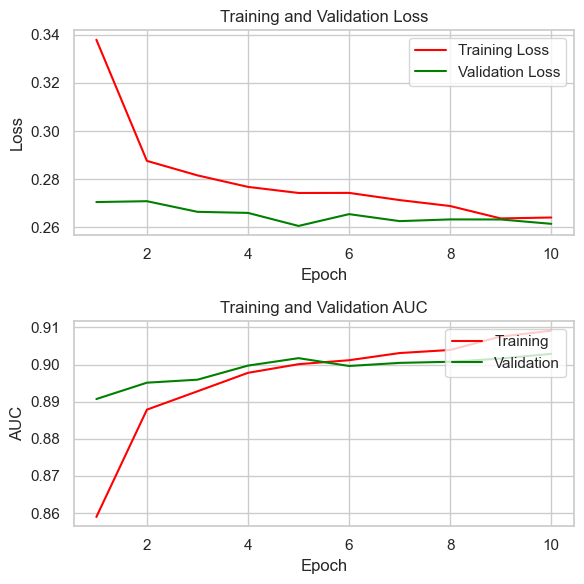

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2734
           1       0.58      0.33      0.42       501

    accuracy                           0.86      3235
   macro avg       0.73      0.64      0.67      3235
weighted avg       0.84      0.86      0.84      3235

ROC AUC score: 0.6435399135890618


In [23]:
simple_classifier_05 = get_simple_model(dropout=0.5)
simple_classifier_05.summary()
history = train_model(simple_classifier_05, X_train, y_train, X_val, y_val)
plot_history(history)
my_classification_report(simple_classifier_05, X_val, y_val)

In [24]:
def residual_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    residual = x
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Add()([x, residual])
    outputs = layers.Dense(1, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 54)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │      7,040 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      4,160 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64)        │          0 │ dropout_8[0][0],  │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │         65 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.5000 - loss: 0.5244 - val_AUC: 0.5000 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - AUC: 0.5000 - loss: 0.3087 - val_AUC: 0.5000 - val_loss: 0.2743 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - AUC: 0.5000 - loss: 0.2905 - val_AUC: 0.5000 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - AUC: 0.5000 - loss: 0.2890 - val_AUC: 0.5000 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - AUC: 0.5000 - loss: 0.2838 - val_AUC: 0.5000 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - AUC: 0.5000 - loss: 0.2776 - val_AUC: 0.5000 - val_loss: 0.2666 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - AUC: 0.5000 - loss: 0.2689 - val_AUC: 0.5000 - val_loss: 0.2639 - learning_

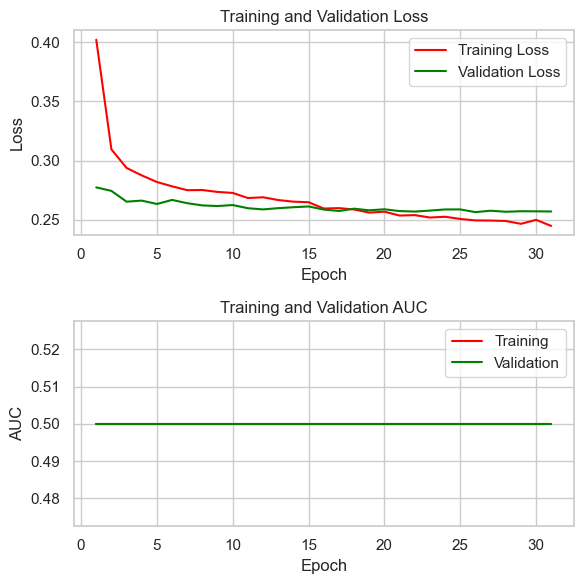

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2734
           1       0.15      1.00      0.27       501

    accuracy                           0.15      3235
   macro avg       0.08      0.50      0.13      3235
weighted avg       0.02      0.15      0.04      3235

ROC AUC score: 0.5


In [25]:
residual_net_classifier = residual_net()
residual_net_classifier.summary()
history = train_model(residual_net_classifier, X_train, y_train, X_val, y_val)
plot_history(history)
my_classification_report(residual_net_classifier, X_val, y_val)

In [26]:
class DropConnect(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(DropConnect, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs


def drop_connect_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation="relu")(inputs)
    x = DropConnect(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = DropConnect(0.2)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = DropConnect(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(
        x
    )  # Use 'sigmoid' activation for binary classification
    model = tf.keras.Model(inputs, outputs)
    return model

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect (DropConnect)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect_1 (DropConnect)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect_2 (DropConnect)    │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - AUC: 0.7716 - loss: 0.4227 - val_AUC: 0.8936 - val_loss: 0.2707 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - AUC: 0.8869 - loss: 0.2885 - val_AUC: 0.8964 - val_loss: 0.2693 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - AUC: 0.8946 - loss: 0.2778 - val_AUC: 0.8981 - val_loss: 0.2660 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - AUC: 0.8991 - loss: 0.2775 - val_AUC: 0.8966 - val_loss: 0.2687 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - AUC: 0.9007 - loss: 0.2706 - val_AUC: 0.8993 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - AUC: 0.9072 - loss: 0.2616 - val_AUC: 0.8980 - val_loss: 0.2659 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - AUC: 0.9030 - loss: 0.2684 - val_AUC: 0.8996 - val_loss: 0.2663 - learnin

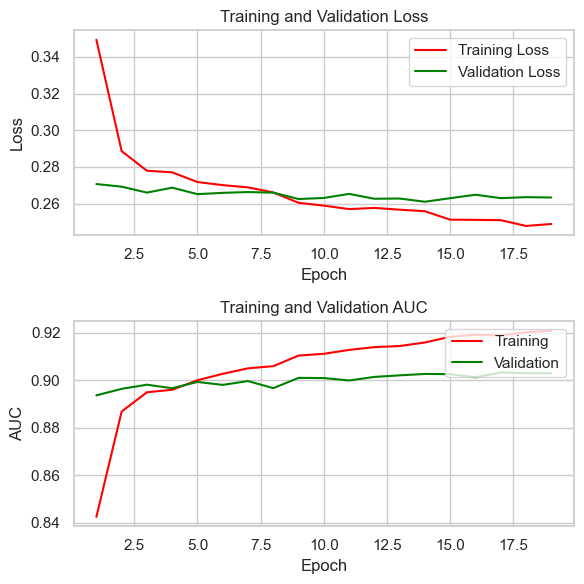

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2734
           1       0.56      0.38      0.45       501

    accuracy                           0.86      3235
   macro avg       0.72      0.66      0.68      3235
weighted avg       0.84      0.86      0.85      3235

ROC AUC score: 0.6620055426820097


In [27]:
drop_connect_net_classifier = drop_connect_net()
drop_connect_net_classifier.summary()
history = train_model(drop_connect_net_classifier, X_train, y_train, X_val, y_val)
plot_history(history)
my_classification_report(drop_connect_net_classifier, X_val, y_val)

In [28]:
def dense_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,305 (71.50 KB)

 Trainable params: 17,857 (69.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.7304 - loss: 0.5764 - val_AUC: 0.8896 - val_loss: 0.2889 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - AUC: 0.8679 - loss: 0.3197 - val_AUC: 0.8960 - val_loss: 0.2747 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - AUC: 0.8740 - loss: 0.3057 - val_AUC: 0.8972 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - AUC: 0.8863 - loss: 0.2969 - val_AUC: 0.8970 - val_loss: 0.2660 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - AUC: 0.8927 - loss: 0.2797 - val_AUC: 0.8986 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - AUC: 0.8904 - loss: 0.2808 - val_AUC: 0.8981 - val_loss: 0.2659 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - AUC: 0.8961 - loss: 0.2743 - val_AUC: 0.9017 - val_loss: 0.2627 - learning_

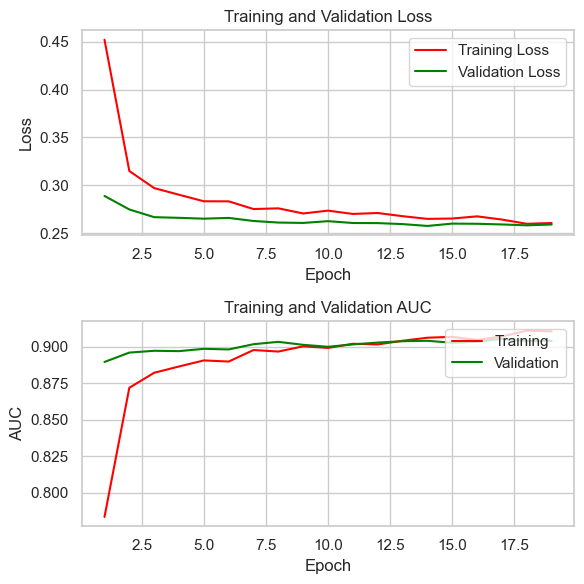

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2734
           1       0.58      0.43      0.49       501

    accuracy                           0.86      3235
   macro avg       0.74      0.68      0.71      3235
weighted avg       0.85      0.86      0.85      3235

ROC AUC score: 0.684860345147306


In [29]:
dense_net_classifier = dense_net()
dense_net_classifier.summary()
history = train_model(dense_net_classifier, X_train, y_train, X_val, y_val)
plot_history(history)
my_classification_report(dense_net_classifier, X_val, y_val)

In [30]:
s = f"\nSCORES\n{'Name':40s}{'auc':10s}\t{'f1_score':10s}\n"
for model, name in [
    (simple_classifier_02, "Simple Classifier (Dropout=0.2)"),
    (simple_classifier_00, "Simple Classifier (Dropout=0.0)"),
    (simple_classifier_05, "Simple Classifier (Dropout=0.5)"),
    (residual_net_classifier, "Residual Net"),
    (drop_connect_net_classifier, "Drop Connect Net"),
    (dense_net_classifier, "Dense Net"),
]:
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    s += f"{name:40s}{roc_auc_score(y_val, y_pred):1.9f}\t{f1_score(y_val, y_pred):1.9f}\n"

print(s)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step

SCORES
Name                                    auc       	f1_score  
Simple Classifier (Dropout=0.2)         0.693110852	0.503954802
Simple Classifier (Dropout=0.0)         0.696272050	0.506666667
Simple Classifier (Dropout=0.5)         0.643539914	0.421319797
Residual Net                            0.500000000	0.268201285
Drop Connect Net                        0.662005543	0.451306413
Dense Net                               0.684860345	0.490825688



So proposed deep learning architectures did not managed to outperform Gaussian Classifier.

# Model Eplanation

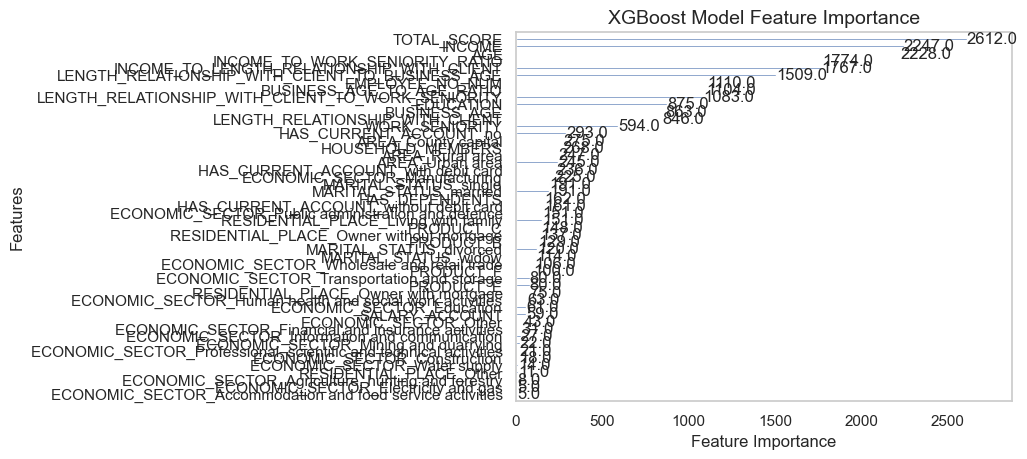

In [31]:
xgboost.plot_importance(
    xgb_classifier,
    xlabel="Feature Importance",
    title="XGBoost Model Feature Importance",
    grid=False,
)

# plt.rcParams['figure.figsize'] = [10, 13]
# plt.rcParams['font.size'] = 12
plt.title("XGBoost Model Feature Importance", fontsize=14)

plt.show()

In [32]:
# xgb_model = xgboost.XGBClassifier(**xgb_params)
xgb_model = xgboost.XGBClassifier()
xgb_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

In [33]:
shap.initjs()

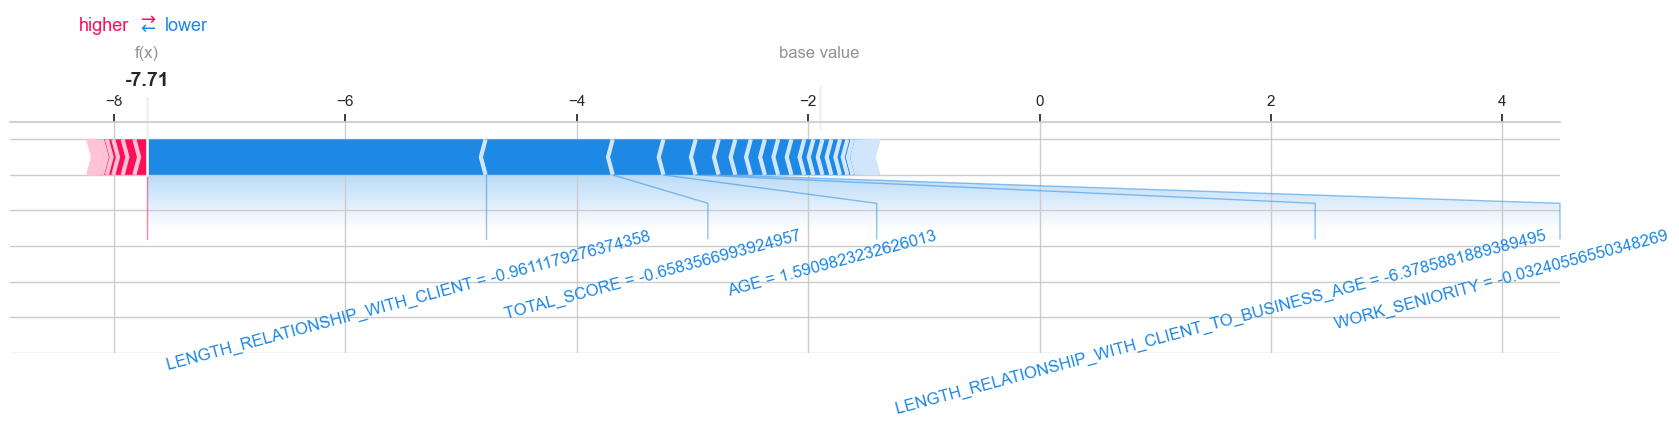

In [34]:
shap.force_plot(
    explainer.expected_value,
    shap_values[2, :],
    X_train.iloc[0, :],
    matplotlib=True,
    text_rotation=15,
)

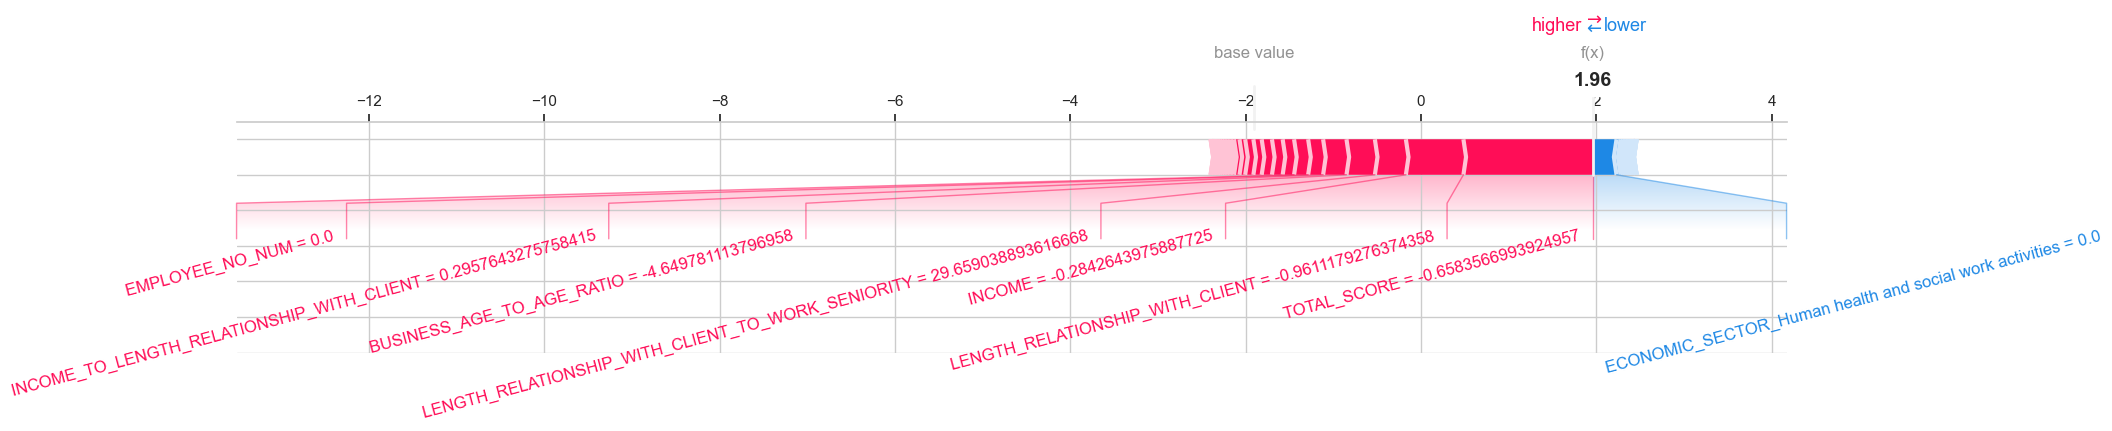

In [35]:
shap.force_plot(
    explainer.expected_value,
    shap_values[110, :],
    X_train.iloc[0, :],
    matplotlib=True,
    text_rotation=15,
)

In [36]:
plot = shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], X_train.iloc[:1000, :]
)
shap.save_html("shap_force_plot.html", plot)

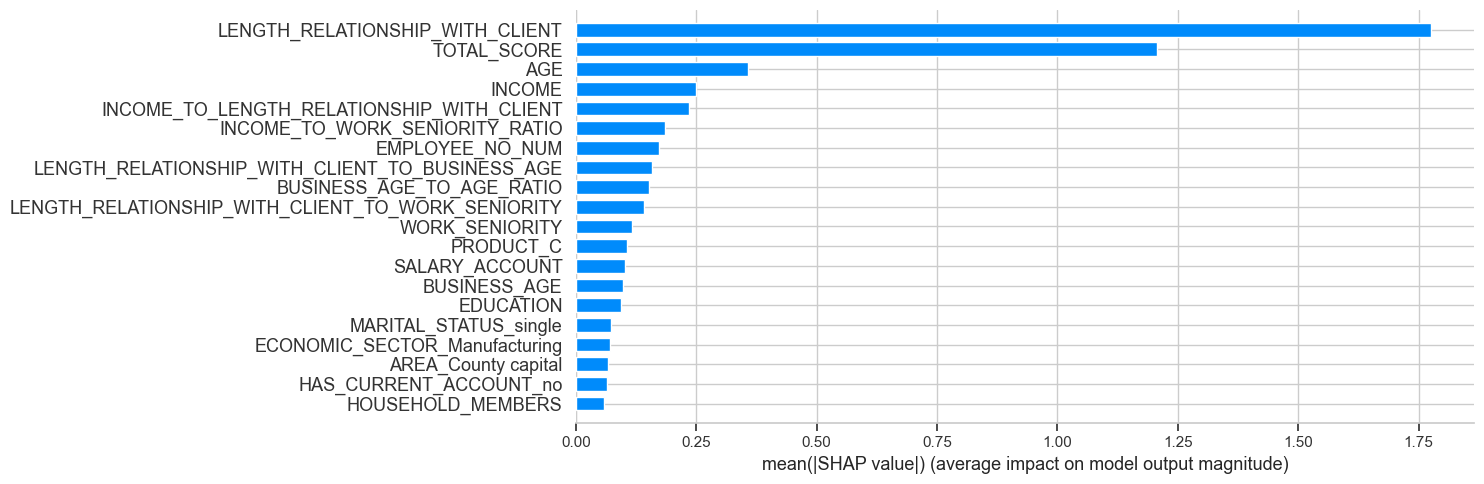

In [37]:
shap.summary_plot(shap_values, X_train, plot_type="bar", plot_size=(15, 5))

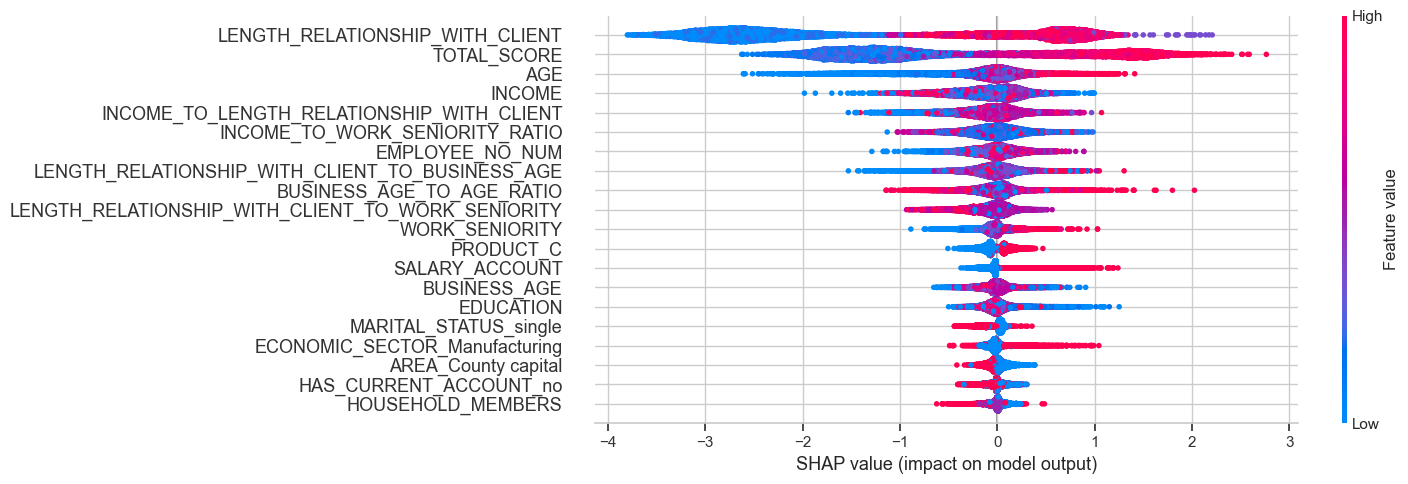

In [38]:
shap.summary_plot(shap_values, X_train, plot_size=(15, 5))

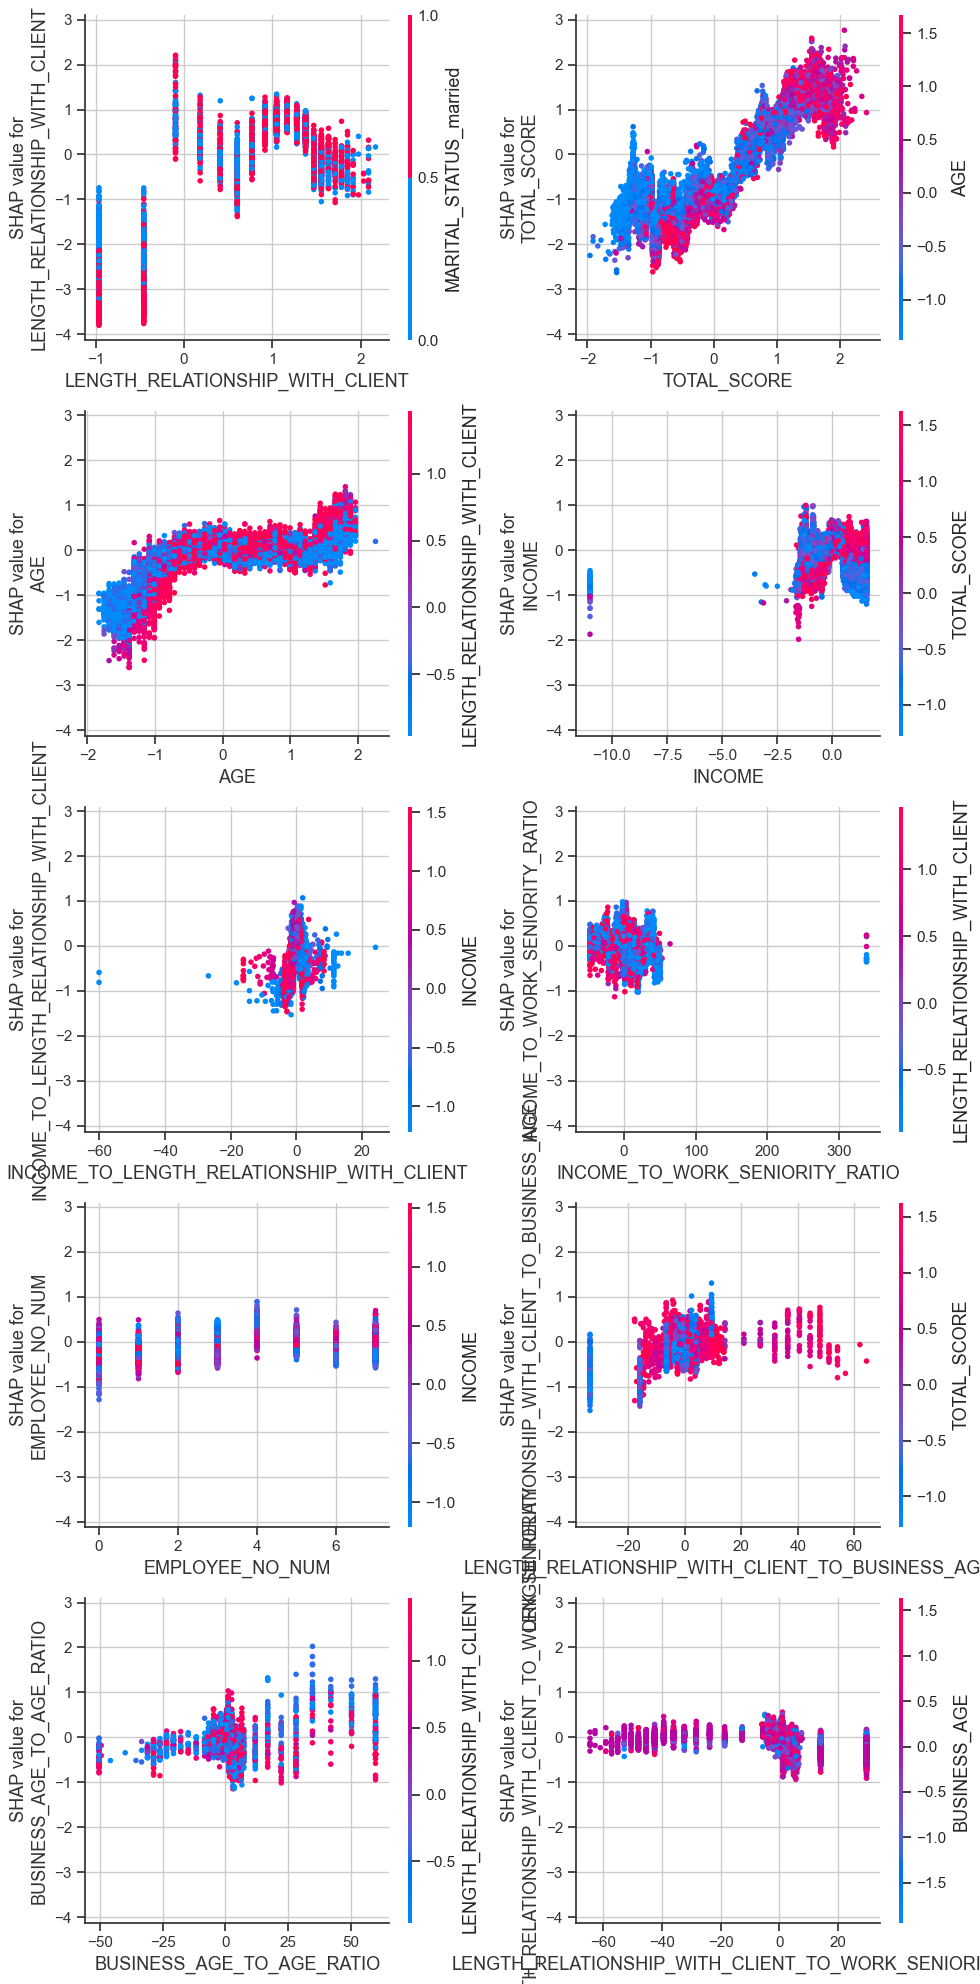

In [39]:
abs_shap_values = np.abs(shap_values).mean(axis=0)
sorted_indices = np.argsort(abs_shap_values)[::-1]
top_10_features = X_train.columns[sorted_indices][:10]

fig, axes = plt.subplots(5, 2, figsize=(10, 20), sharey=True)
axes = axes.flatten()
for i, name in enumerate(top_10_features):
    shap.dependence_plot(
        name, shap_values, X_train, display_features=X_train, ax=axes[i], show=False
    )

plt.tight_layout()
plt.show()

# Final model

Based on above research we'll go into production with our voting classifier. We believe it'll have best generalization capabilities and it will focus more on recall to precision.

In [40]:
df_val = pd.read_csv("../data/orig_valid.csv")
y_val = df_val["FINALIZED_LOAN"]
df_val.drop(columns=["FINALIZED_LOAN"], inplace=True)

final_model = FinalModel(pipeline, gaussian_classifier)
y_pred = final_model.predict(df_val)

In [41]:
my_classification_report(final_model, df_val, y_val)

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      2734
           1       0.47      0.85      0.60       501

    accuracy                           0.83      3235
   macro avg       0.72      0.84      0.75      3235
weighted avg       0.89      0.83      0.85      3235

ROC AUC score: 0.8361853469359743


In [42]:
joblib.dump(final_model, "../pipelines/final_model.joblib")

['../pipelines/final_model.joblib']